# Analysis of the results

This notebook investigates the results of running this analysis.

## Imports and hardcoded variables

In [1]:
import json
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

from matplotlib import pyplot as plt
from pprint import pprint
from sphincter.data_preparation import load_prepared_data

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [2]:
idatas = {
    d: az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, d, "idata"))
    for d in os.listdir(INFERENCES_DIR)
    if os.path.isdir(os.path.join(INFERENCES_DIR, d))
}
idatas_q1 = {k: v for k, v in idatas.items() if "q1" in k}
idatas_q2 = {k: v for k, v in idatas.items() if "q2" in k}
idatas["q2"]

Inference data with groups:
	> observed_data

In [3]:
raw = pd.read_csv("../data/raw/data_sphincter_paper.csv")

# Plot measurements

In [4]:
q1_data = load_prepared_data("../data/prepared/q1")

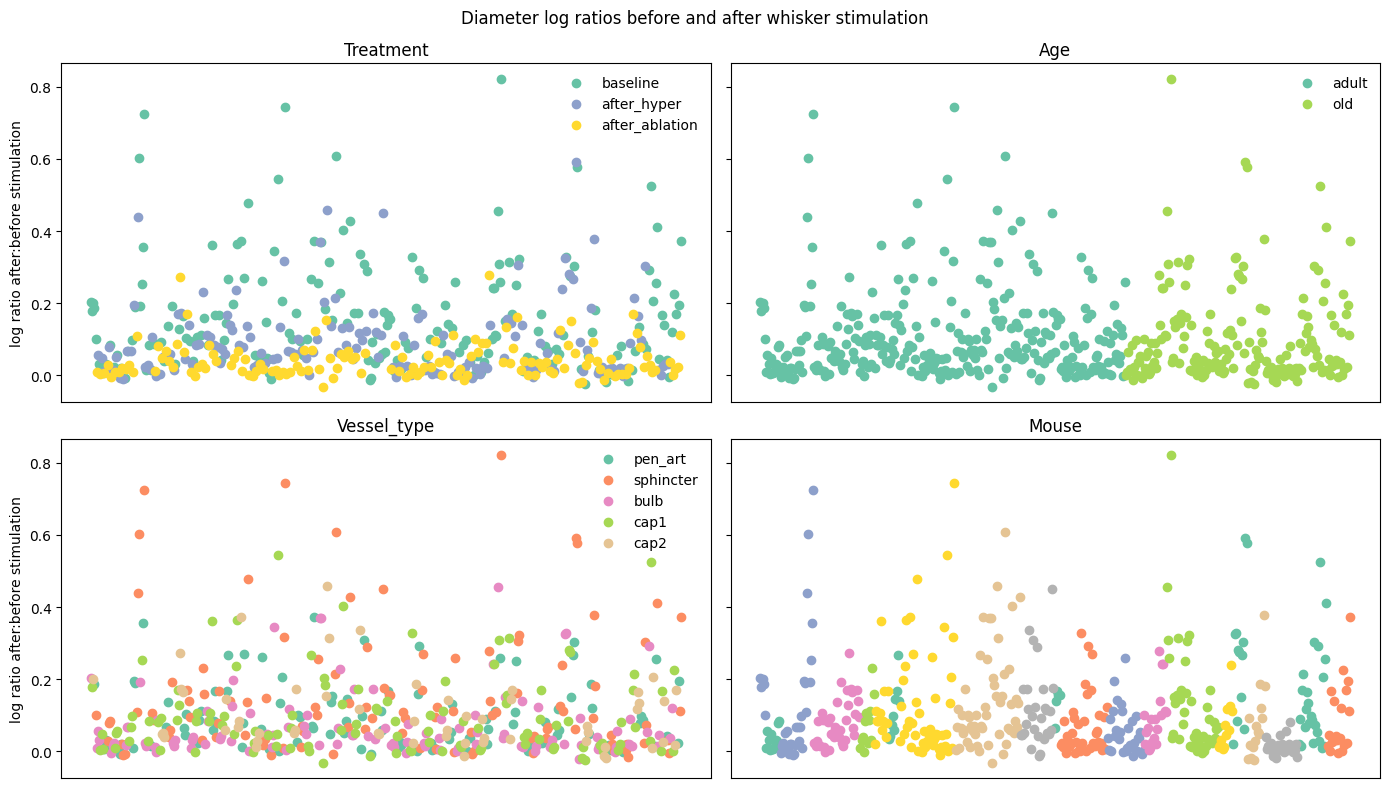

In [5]:
def plot_raw_data(ax, obs, **scatter_kwargs):
    x = np.linspace(*ax.get_xlim(), len(obs))
    ax.set_xticks([]);
    return ax.scatter(x, obs, **scatter_kwargs);

def get_colors(col, cmap):
    
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm)
    return {cat: scalarMap.to_rgba(i) for i, cat in enumerate(col.cat.categories)}


def plot_raw_data_cat(ax, obs, catcol, cmap, weird_level=None):
    cNorm = mpl.colors.Normalize(vmin=0, vmax=len(catcol.cat.categories))
    x = pd.Series(np.linspace(*ax.get_xlim(), len(obs)), index=obs.index)
    scts = []
    for i, cat in enumerate(catcol.cat.categories):
        color = cmap(cNorm(i))
        y = obs.loc[catcol == cat]
        xcat = x.loc[y.index]
        scts.append(ax.scatter(xcat, y, label=cat, color=color))
        if weird_level is not None:
            for i, yi in y.items():
                if yi > weird_level:
                    ax.text(xcat.loc[i], yi, "?")
    return scts
    
obs = q1_data.measurements["diam_log_ratio"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = q1_data.measurements[col]
    plot_raw_data_cat(ax, obs, catcol, cmap=cmap, weird_level=1.0)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("log ratio after:before stimulation");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
f.suptitle("Diameter log ratios before and after whisker stimulation");
f.tight_layout()

f.savefig(os.path.join(PLOTS_DIR, "whisker-measurements-faceted.png"), bbox_inches="tight")

## Comparing in and out of sample log likelihoods

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected posterior log predictive density for each inference.

It then calculates the average posterior in and out of sample log likelihoods.

In [6]:
idatas_to_compare = {k: v for k, v in idatas.items() if "q1" in k and "log_likelihood" in v.groups()}
if len(idatas_to_compare.keys()) == 1:
    validation = az.loo(next(iter(idatas_to_compare.values())))
elif len(idatas_to_compare.keys()) > 1:
    validation = az.compare(idatas_to_compare)
display(validation)

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
q1-ind,0,380.514702,184.893842,0.000000,0.820762,38.352126,0.000000,False,log
q1-flat,1,209.681103,809.059186,170.833599,0.179238,33.567250,25.240498,True,log


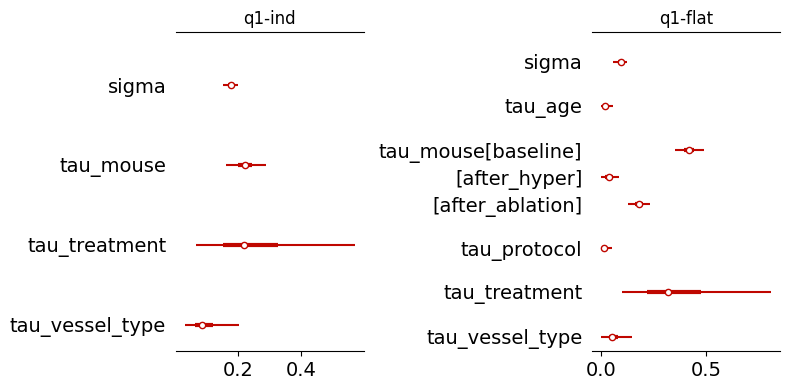

In [7]:
f, axes = plt.subplots(1, 2, figsize=[8, 4])
for (name, idata), ax in zip(idatas_q1.items(), axes):
    az.plot_forest(
        idata,
        var_names=["sigma", "tau"],
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.set_title(name)
plt.tight_layout()

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['a_vtm'] have not been found and will be ignored
  warnings.warn(
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['a_vtm'] have not been found and will be ignored
  warnings.warn(


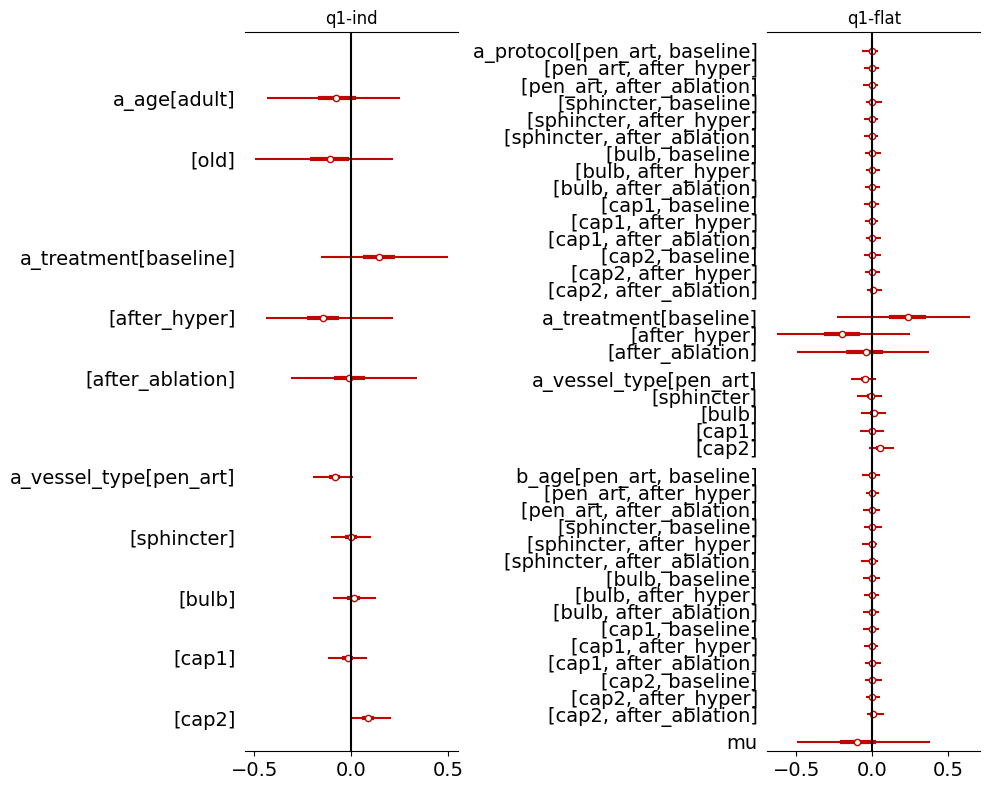

In [8]:
f, axes = plt.subplots(1, 2, figsize=[10, 8])
for (name, idata), ax in zip(idatas_q1.items(), axes):
    az.plot_forest(
        idata,
        var_names=["~a_mouse", "~_z", "~tau", "~nu", "~sigma", "~a_vtm"], 
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.set_title(name)
    ax.axvline(0, color="black")
plt.tight_layout()

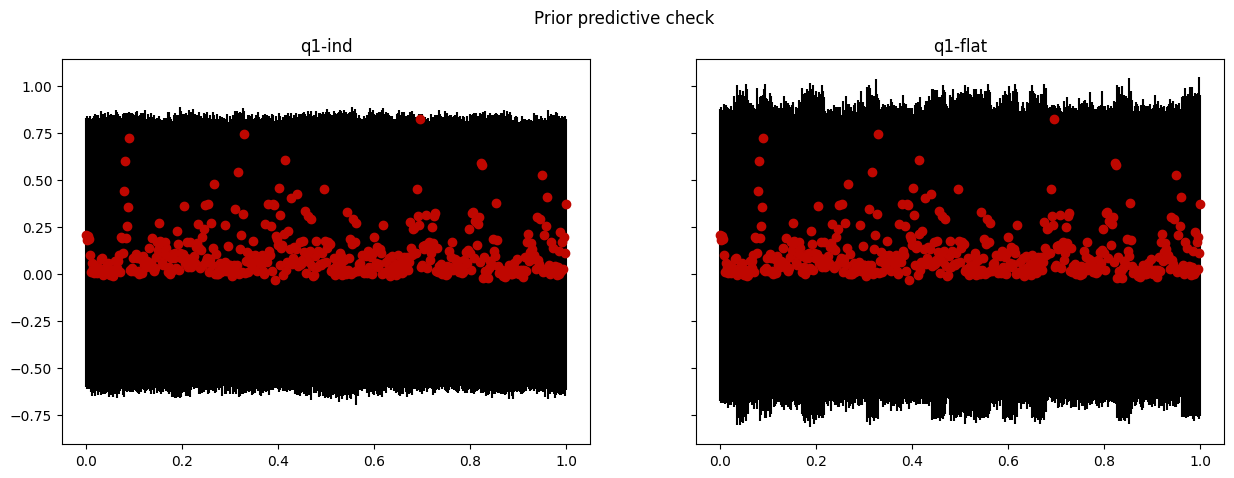

In [9]:
f, axes = plt.subplots(1, len(idatas_q1.values()), figsize=[15, 5], sharey=True)
f.suptitle("Prior predictive check")

for ax, (name, idata) in zip(axes, idatas_q1.items()):
    yobs = xr.DataArray(
        idata.observed_data["y"].values, 
        coords={"observation": idata.prior_predictive.coords["observation"]}
    )
    yrep = idata.prior_predictive["yrep"]
    qs = yrep.quantile([0.025, 0.975], dim=["chain", "draw"])
    x = np.linspace(*ax.get_xlim(), len(yobs))
    ax.scatter(x, yobs);
    ax.vlines(x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), color="black", zorder=-1);
    ax.set_title(name);
f.savefig(os.path.join(PLOTS_DIR, "whisker-prior-check.png"), bbox_inches="tight")

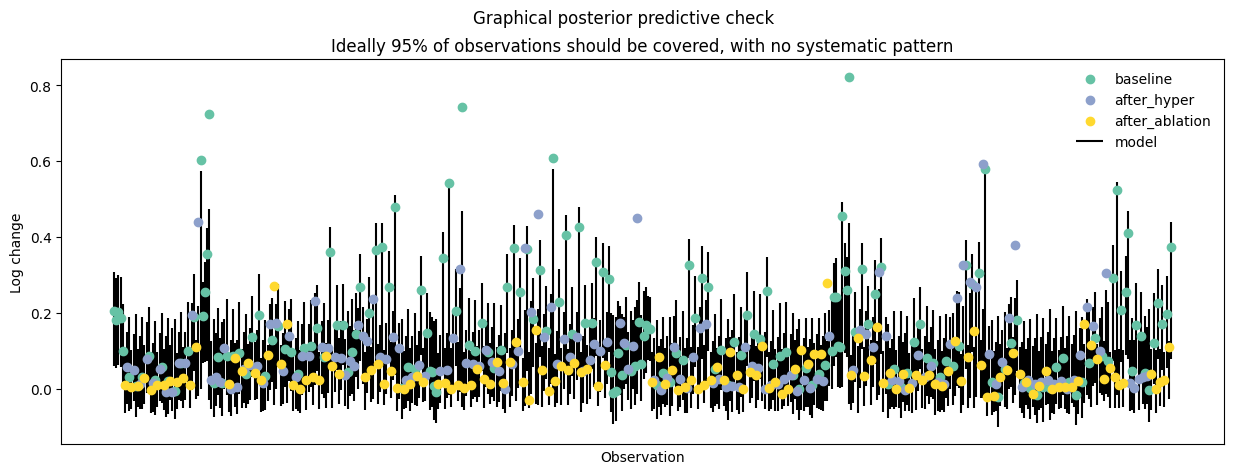

In [10]:
f, ax = plt.subplots(figsize=[15, 5])

yobs = pd.Series(xr.DataArray(
    idatas["q1-flat"].observed_data["y"].values, 
    coords={"observation": idatas["q1-flat"].posterior_predictive.coords["observation"]}
).values, index=q1_data.measurements.index)
yrep = idatas["q1-flat"].posterior_predictive["yrep"]
qs = yrep.quantile([0.025, 0.975], dim=["chain", "draw"])
x = np.linspace(*ax.get_xlim(), len(yobs))
plot_raw_data_cat(ax, yobs, q1_data.measurements["treatment"], cmap=cmap)
ax.vlines(x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), color="black", zorder=-1, label="model");
ax.set_xticks([])
ax.legend(frameon=False);
ax.set(
    title="Ideally 95% of observations should be covered, with no systematic pattern",
    ylabel="Log change",
    xlabel="Observation"
);
f.suptitle("Graphical posterior predictive check");
f.savefig(os.path.join(PLOTS_DIR, "whisker-posterior-check.png"), bbox_inches="tight")

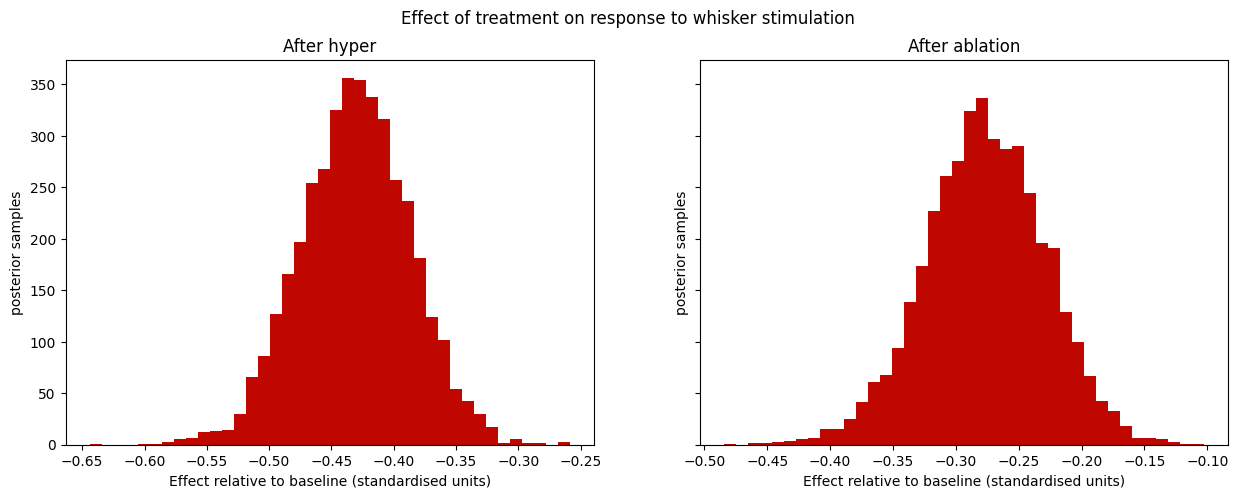

In [11]:
diff = idatas["q1-flat"].posterior["a_treatment"] - idatas["q1-flat"].posterior["a_treatment"].sel(treatment="baseline")

f, axes = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
f.suptitle("Effect of treatment on response to whisker stimulation")
for treatment, ax in zip(["after_hyper", "after_ablation"], axes):
    ax.set(
        title=f"{treatment.capitalize().replace('_', ' ')}",
        ylabel="posterior samples",
        xlabel="Effect relative to baseline (standardised units)"
    )
    ax.hist(diff.sel(treatment=treatment).values.flatten(), bins=40)
f.savefig(os.path.join(PLOTS_DIR, "whisker-treatment-effects.png"), bbox_inches="tight")

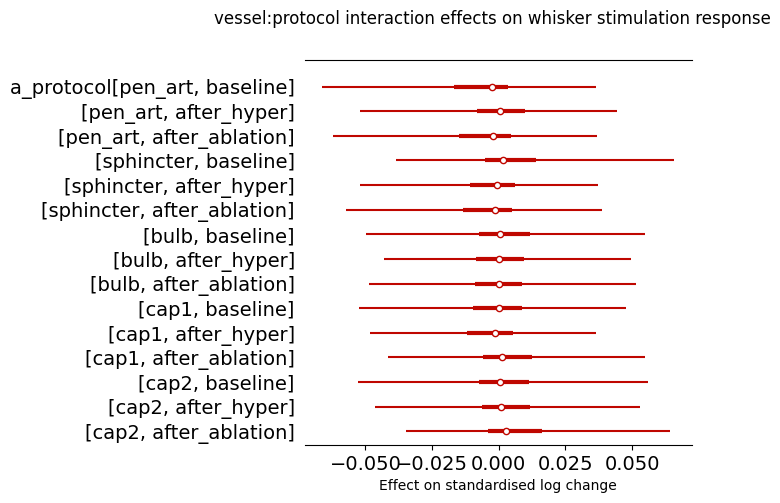

In [12]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("vessel:protocol interaction effects on whisker stimulation response")
az.plot_forest(
        idatas["q1-flat"],
        var_names="a_protocol",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Effect on standardised log change",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-protocol-effects.png"), bbox_inches="tight")

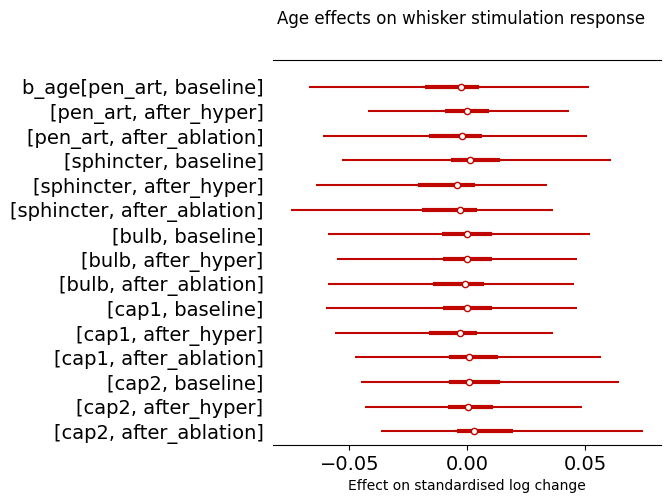

In [13]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Age effects on whisker stimulation response")
az.plot_forest(
        idatas["q1-flat"],
        var_names="b_age",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Effect on standardised log change",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-age-effects.png"), bbox_inches="tight")

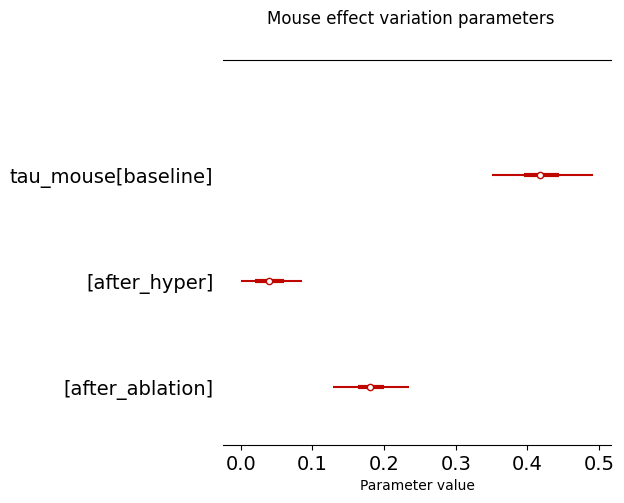

In [14]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Mouse effect variation parameters")
az.plot_forest(
        idatas["q1-flat"],
        var_names="tau_mouse",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Parameter value",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-tau-mouse.png"), bbox_inches="tight")

<xarray.DataArray 'a_vessel_type' (chain: 4, draw: 1000, vessel_type: 4)>
array([[[-0.0330728 ,  0.0157856 ,  0.0704053 ,  0.0683498 ],
        [ 0.0239397 ,  0.0021887 ,  0.00589434,  0.07953536],
        [ 0.053027  ,  0.0755998 , -0.0777792 ,  0.107926  ],
        ...,
        [ 0.08637958,  0.08086662, -0.065837  ,  0.0789745 ],
        [ 0.0272748 , -0.0275404 ,  0.02755   ,  0.0971902 ],
        [-0.0432065 ,  0.0768206 , -0.005212  ,  0.084475  ]],

       [[ 0.03052199,  0.07119411, -0.07404289,  0.11514509],
        [ 0.133273  , -0.0210185 ,  0.007869  ,  0.04147069],
        [ 0.0627342 , -0.00827946,  0.00975326,  0.0484295 ],
        ...,
        [ 0.1171174 ,  0.0082425 ,  0.0300678 ,  0.0304397 ],
        [ 0.08407505,  0.03302875, -0.0246472 ,  0.0971486 ],
        [ 0.0465435 ,  0.02834889,  0.00422081,  0.072788  ]],

       [[ 0.03113956,  0.07026304, -0.0226908 ,  0.0270023 ],
        [ 0.04104281,  0.06223459, -0.0477012 ,  0.0810024 ],
        [ 0.01716765, -0.00120403,  0.00648222,  0.00364946],
        ...,
        [ 0.02157312, -0.01601521,  0.01005291,  0.0827573 ],
        [ 0.05130034,  0.0537736 , -0.0845169 ,  0.0424783 ],
        [ 0.04724592,  0.00691278,  0.0102061 ,  0.0160859 ]],

       [[ 0.08768197,  0.04521843, -0.0709488 ,  0.0560364 ],
        [ 0.0603624 ,  0.058403  , -0.02496524,  0.04560134],
        [ 0.1034799 , -0.033108  ,  0.0539382 ,  0.0263389 ],
        ...,
        [ 0.07676622,  0.01939988,  0.0021319 ,  0.0210411 ],
        [ 0.1065315 , -0.0845353 ,  0.01812295,  0.04404945],
        [ 0.0515009 , -0.02528716,  0.00572244,  0.04232242]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * vessel_type  (vessel_type) <U9 'sphincter' 'bulb' 'cap1' 'cap2'

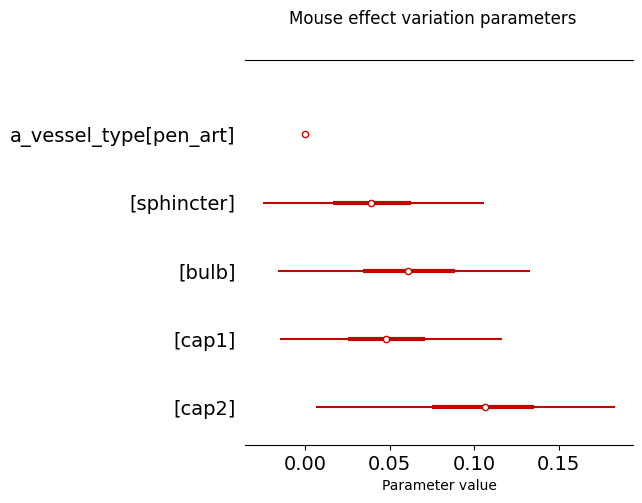

In [28]:
diff = idatas["q1-flat"].posterior["a_vessel_type"] - idatas["q1-flat"].posterior["a_vessel_type"].sel(vessel_type="pen_art")

f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Mouse effect variation parameters")
az.plot_forest(
        diff,
        var_names="a_vessel_type",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Parameter value",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-tau-mouse.png"), bbox_inches="tight")

# Q2

In [15]:
[c for c in raw.columns if "pressure" in c]

['pressure_d',
 'pressure_s',
 'pressure_before_hypertension',
 'pressure_start_hypertension',
 'pressure_min_hypertension',
 'pressure_before_stop_hypertension',
 'pressure_after_hypertension']

In [16]:
q2_data = load_prepared_data("../data/prepared/q2")

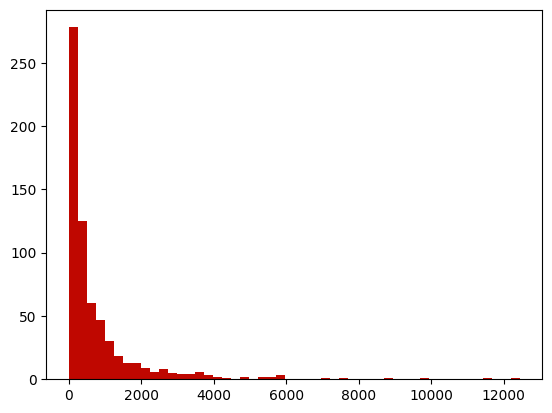

In [17]:
f, ax = plt.subplots()
ax.hist(q2_data.measurements["pd1"], bins=50);

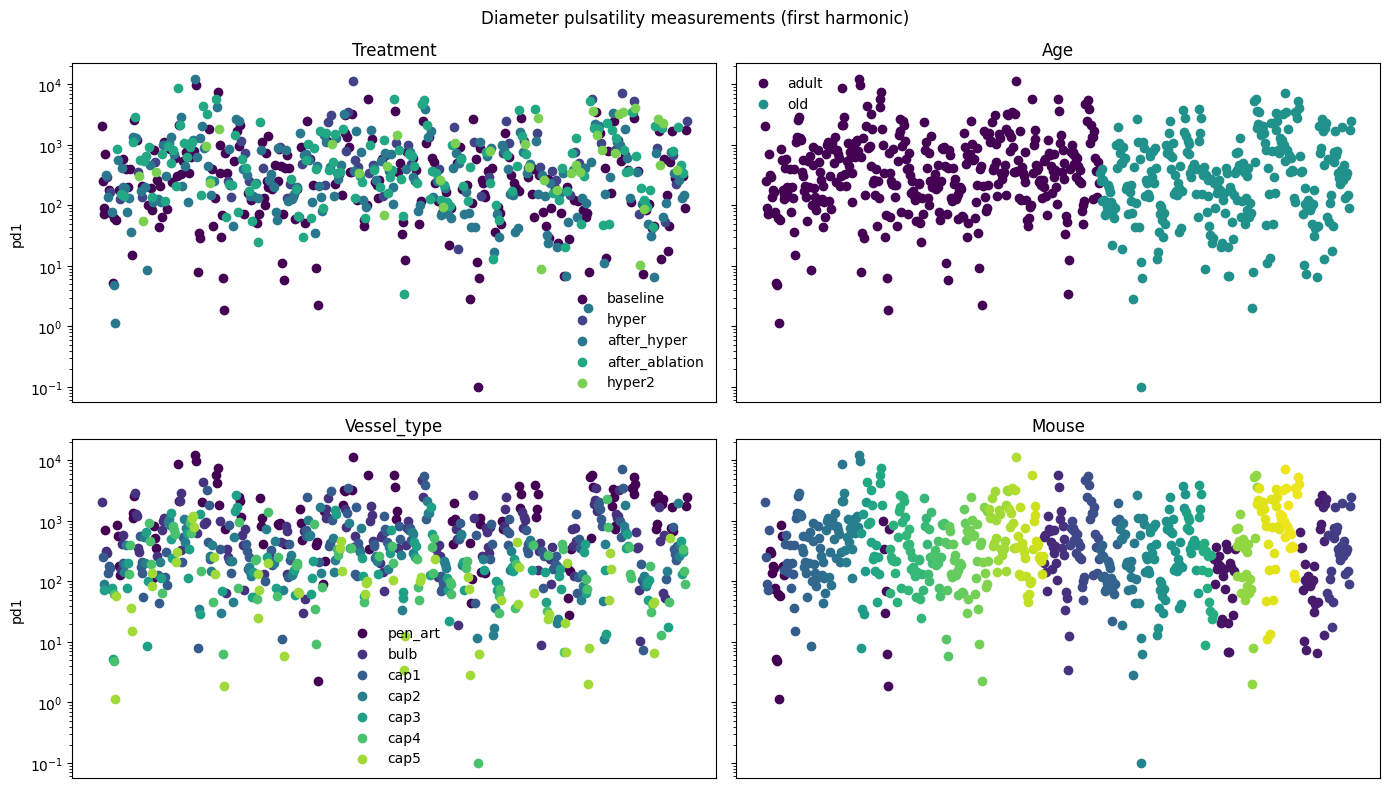

In [18]:
obs = q2_data.measurements["pd1"]
cmap = mpl.colormaps["viridis"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = q2_data.measurements[col]
    plot_raw_data_cat(ax, obs, catcol, cmap=cmap, weird_level=None)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()

AttributeError: 'InferenceData' object has no attribute 'posterior_predictive'

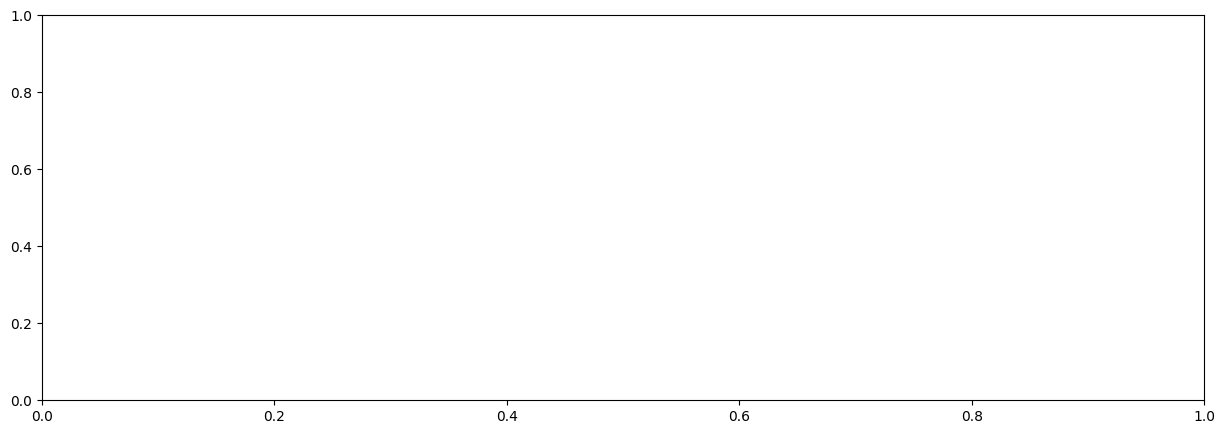

In [19]:
f, axes = plt.subplots(1, len(idatas_q2.values()), figsize=[15, 5])
axes = [axes]

for ax, (name, idata) in zip(axes, idatas_q2.items()):
    yobs = xr.DataArray(
        idata.observed_data["y"].values, 
        coords={"observation": idata.posterior_predictive.coords["observation"]}
    )
    yrep = idata.posterior_predictive["yrep"]
    qs = yrep.quantile([0.025, 0.975], dim=["chain", "draw"])
    x = np.linspace(*ax.get_xlim(), len(yobs))
    ax.scatter(x, yobs);
    ax.vlines(x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), color="black", zorder=-1);
    ax.set_title(name);
    ax.semilogy()

In [ ]:
az.loo(idatas["q2"], pointwise=True)

In [ ]:
f, axes = plt.subplots(1, len(idatas_q2.items()), figsize=[5, 4])
axes = [axes]
for (name, idata), ax in zip(idatas_q2.items(), axes):
    az.plot_forest(
        idata,
        var_names=["sigma", "tau"],
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.set_title(name)
plt.tight_layout()

In [ ]:
f, axes = plt.subplots(1, len(idatas_q2.items()), figsize=[8, 5])
axes = [axes]
for (name, idata), ax in zip(idatas_q2.items(), axes):
    az.plot_forest(
        idata,
        var_names=["a_age", "a_treatment", "a_vessel_type"], 
        combined=True,
        ax=ax
    );
    ax.set_title(name)
    ax.axvline(0, color="black")
plt.tight_layout()